# Amazon Fine Food Analysis

# 1 Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

con = sqlite3.connect('database.sqlite') #loading data

#filtering only positive and negative reviews
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# renaming the score with less than 3 to negative and more than 3 to positive
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print("number of attributes and size of the data is")
print(filtered_data.shape) #number of attributes and size of the data
filtered_data.head() # prints first few rows

C:\Users\tm00501760\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


number of attributes and size of the data is
(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Observations:

Load the dataset for Amazon Food Reviews and segergate dataset based on positive and negative reviews i.e., reviews with ratings less than 3 is considered to be negative reviews and reviews with rating greater than 3 is considered to be positive review.

# 2 Data Cleaning

# 2.1 Deduplicating

In [2]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print("Size of sorted data according to the product id:")
print(sorted_data.shape)

#removing the duplicate entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

print("Size after removing the duplicate entries:")
print(final.shape)

#Number of positive and negative reviews present in sorted dataset:
print("Number of positive and negative reviews present in sorted dataset:")
final['Score'].value_counts()

Size of sorted data according to the product id:
(525814, 10)
Size after removing the duplicate entries:
(364171, 10)
Number of positive and negative reviews present in sorted dataset:


positive    307061
negative     57110
Name: Score, dtype: int64

# Observation:

Resultant is the output after removing the duplicates based on unique product Id.

# 2.2 Stemming

In [3]:
import nltk
from nltk.stem import SnowballStemmer
import re
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to remove html tagged words
def removehtml(sentence): 
    remove = re.compile('<.*?>')
    removetext = re.sub(remove, ' ', sentence)
    return removetext

#function to remove word of any pinctuation and special characters
def removepunct(sentence): 
    removed = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    removed = re.sub(r'[.|,|)|(|\|/]',r' ',removed)
    return  removed

print("Stop words found in the given dataset are:")
print(stop)

Stop words found in the given dataset are:
{"that'll", 'once', 'so', 'y', 'does', 'did', 'won', 'out', 'some', 'if', 'him', 'yours', 'the', 'at', "hasn't", 'and', "mightn't", 'not', 'by', 'too', 'll', "wouldn't", 't', 'hers', 'they', 'very', 'above', 'nor', 'wasn', 'can', 'my', 'what', 'be', 'is', 'she', 'doing', 'having', 'few', "should've", "you've", "haven't", 'mustn', "wasn't", 'its', 'again', 'her', 'to', "couldn't", 'shan', 've', 'me', 'couldn', 'a', 'during', 'am', 'whom', 'these', "isn't", 're', 'now', 'there', 'off', "aren't", 'do', 'when', 'own', 'that', 'most', 'didn', 'itself', 'myself', 'in', 'on', 'into', 'haven', 'aren', "you'll", 'yourself', 'any', 'himself', "won't", 'their', 'his', 'were', 'between', 'doesn', 'why', 'd', 'isn', 'after', 'ma', 'while', 'about', 'no', 'shouldn', "doesn't", 'before', "you'd", 'up', 'only', 'i', "shouldn't", 'weren', 'with', 'all', 'o', "you're", 'both', 'had', "hadn't", "it's", 'you', 'than', 'ourselves', 'over', 'for', 'should', 'theirs

In [4]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=removehtml(sent) # calling function to remove HTMl tags
    for w in sent.split():
        for cleaned_words in removepunct(w).split(): #calling the function to remove punctuations and special characters and then split sentences into words 
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [5]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [6]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Observation:

Stemming is performed on the deduplicated data to remove stop words and special characters. And finally store the pre-processed dataset.

# 2.3 Considering 4000 samples from 364k dataset

In [7]:
positive_reviews=final[final["Score"]=="positive"].sample(n=1000)
negative_reviews=final[final["Score"]=="negative"].sample(n=1000)
final_4k=pd.concat([positive_reviews,negative_reviews])
print("Shape of 4k dataset")
print(final_4k.shape)
score_4k=final_4k["Score"]
print("Shape of 4k scores only:")
print(score_4k.shape)

Shape of 4k dataset
(2000, 11)
Shape of 4k scores only:
(2000,)


# Observation:

Considering the randon 2000 data points i.e., 1000 data points of positive reviews and negative reviews from the preprocessed data to reduce time complexity.

# 3 t-SNE Representations:

# 3.1 BOW

In [17]:
count_vector=CountVectorizer(ngram_range=(1,2))
final_count=count_vector.fit_transform(final_4k['CleanedText'].values)
print("Type of final count:")
print(type(final_count))
print("Shape of final count:")
print(final_count.shape)

Type of final count:
<class 'scipy.sparse.csr.csr_matrix'>
Shape of final count:
(2000, 68387)


In [19]:
from sklearn.preprocessing import StandardScaler

standard_data = StandardScaler(with_mean = False).fit_transform(final_count)
standard_data = standard_data.todense()
print("Type of standard count:")
print(type(standard_data))
print("Shape of standard count:")
print(standard_data.shape)

Type of standard count:
<class 'numpy.matrixlib.defmatrix.matrix'>
Shape of standard count:
(2000, 68387)


C:\Users\tm00501760\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tm00501760\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


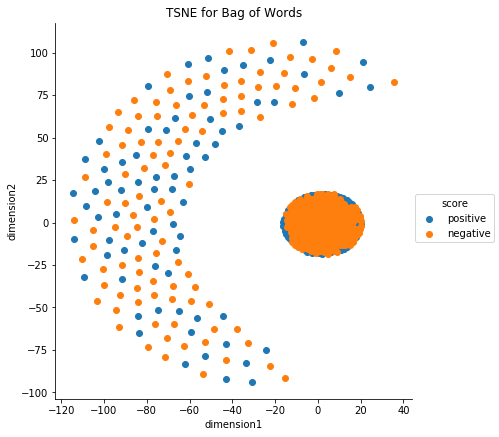

In [20]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(standard_data)
tsne_data = np.vstack((tsne_data.T, score_4k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dimension1", "dimension2", "score"))
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# Observation:

From the above representation, there is large number of overlap and it is unable to seperate positive and negative reviews.

# 3.2 TF-IDF

In [12]:
tfidf_vector=TfidfVectorizer(ngram_range=(1,2))
final_tfidf=tfidf_vector.fit_transform(final_4k['CleanedText'].values)
print("Type of final_tfidf count:")
print(type(final_tfidf))
print("Shape of final_tfidf count:")
print(final_tfidf.shape)

standard_data = StandardScaler(with_mean = False).fit_transform(final_tfidf)
standard_data = standard_data.todense()
print("Type of standard ifidf:")
print(type(standard_data))
print("Shape of standard ifidf:")
print(standard_data.shape)

Type of final_tfidf count:
<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_tfidf count:
(2000, 66666)
Type of standard ifidf:
<class 'numpy.matrixlib.defmatrix.matrix'>
Shape of standard ifidf:
(2000, 66666)


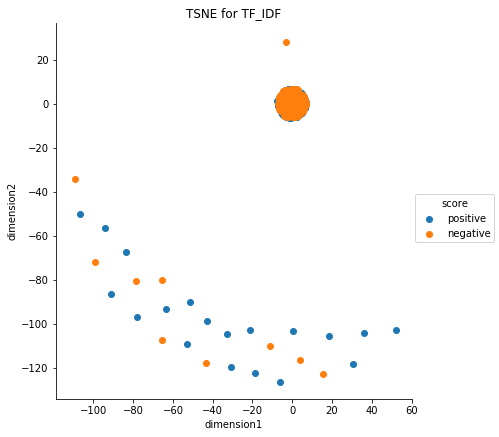

In [12]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity = 30)
tsne_data = model.fit_transform(standard_data)
tsne_data = np.vstack((tsne_data.T, score_4k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dimension1", "dimension2", "score"))
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for TF_IDF")
plt.show()

# Observation:

Seperation between the positive and negative reviews are difficult because of over-lapping.

# 3.3 Avg w2v

In [15]:
import gensim
list_of_sent = []
for sent in final_4k['Text'].values:
    filtered_sentence = []
    sent=removehtml(sent)
    for w in sent.split():
        for cleaned_words in removepunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

print(final_4k['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])
print(final_4k.shape)

I have been suffering from chronic constipation my whole life. Four to nine days of misery was my regular life. Nothing helped me for more than two times. A colleague of mine recommended me this product and since I tried it I'm very regular! It is not like the other products I tried (and I really tried a lot of them)that helped me just a couple of times and afterwards no effect anymore. In addition the frequent muscle cramps I use to have have disappeared. In summary I LOVE LOVE LOVE this product, I'm not going to stop taking it anymore!
*****************************************************************
['i', 'have', 'been', 'suffering', 'from', 'chronic', 'constipation', 'my', 'whole', 'life', 'four', 'to', 'nine', 'days', 'of', 'misery', 'was', 'my', 'regular', 'life', 'nothing', 'helped', 'me', 'for', 'more', 'than', 'two', 'times', 'a', 'colleague', 'of', 'mine', 'recommended', 'me', 'this', 'product', 'and', 'since', 'i', 'tried', 'it', 'im', 'very', 'regular', 'it', 'is', 'not', '

In [16]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 
w2v = w2v_model[w2v_model.wv.vocab]
w2v.shape

(2557, 50)

In [17]:
words = list(w2v_model.wv.vocab)
print(len(words))

2557


In [18]:
w2v_model.wv.most_similar('tasty')

[('delicious', 0.9993318319320679),
 ('salty', 0.9992820024490356),
 ('pretty', 0.9992383718490601),
 ('healthy', 0.9992357492446899),
 ('bar', 0.9991680979728699),
 ('real', 0.9991409778594971),
 ('snack', 0.9991224408149719),
 ('also', 0.9990518093109131),
 ('rich', 0.9990414381027222),
 ('light', 0.9990360140800476)]

In [19]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


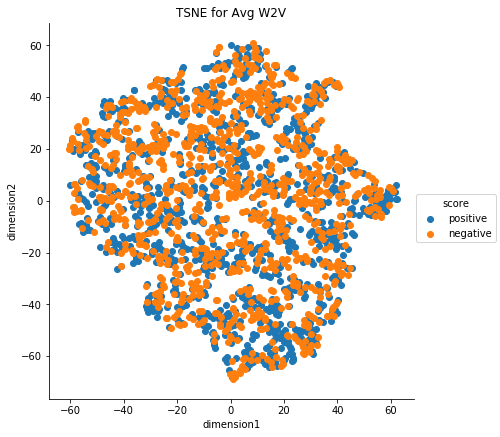

In [18]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_4k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dimension1", "dimension2", "score"))
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Avg W2V")
plt.show()

# 3.4 Avg ifidf

In [21]:
tfidf_feat = tfidf_vector.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
   
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1            

In [22]:
len(tfidf_sent_vectors)

2000

In [23]:
np.isnan(tfidf_sent_vectors)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [24]:
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

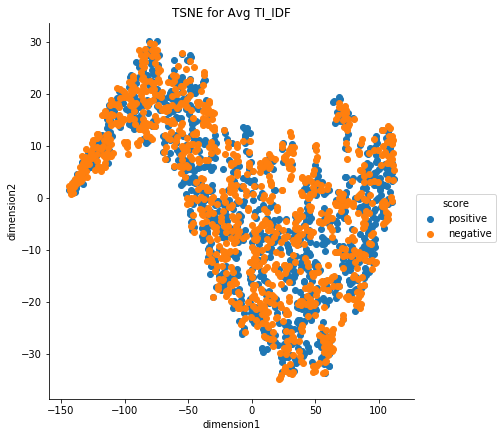

In [25]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_4k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dimension1", "dimension2", "score"))
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Avg TI_IDF")
plt.show()

# Conclusion:

1. From the above representations, non of the t-SNE plots gives the seperation between positive and negative reviews.
2. Above plots may vary based on attributes like no. of data points considered, iterations, perplexity etc.